#### Importating Necessary Libraries

In [0]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from pyspark.sql.functions import col, explode
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import RFormula
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
mlflow.pyspark.ml.autolog()

#### Creating SparkSession And Loading Dataset Into A Spark DataFrame

In [0]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Steam Recommender System") \
    .getOrCreate()

In [0]:
# Load the dataset into a Spark DataFrame with header and inferring schema
steam_df = spark.read.csv("dbfs:/FileStore/tables/steam_200k.csv", header=True, inferSchema=True) \
                .toDF("UserID", "game_name", "User_Behavior", "Hours_Played")


In [0]:
# Show the schema and first few rows of the DataFrame
steam_df.printSchema()
steam_df.show(5)


root
 |-- UserID: integer (nullable = true)
 |-- game_name: string (nullable = true)
 |-- User_Behavior: string (nullable = true)
 |-- Hours_Played: double (nullable = true)

+---------+--------------------+-------------+------------+
|   UserID|           game_name|User_Behavior|Hours_Played|
+---------+--------------------+-------------+------------+
|151603712|The Elder Scrolls...|         play|       273.0|
|151603712|           Fallout 4|     purchase|         1.0|
|151603712|           Fallout 4|         play|        87.0|
|151603712|               Spore|     purchase|         1.0|
|151603712|               Spore|         play|        14.9|
+---------+--------------------+-------------+------------+
only showing top 5 rows



In [0]:
# Summary statistics of numerical columns
print("Summary statistics of numerical columns:")
steam_df.describe().show()

Summary statistics of numerical columns:
+-------+--------------------+----------------+-------------+------------------+
|summary|              UserID|       game_name|User_Behavior|      Hours_Played|
+-------+--------------------+----------------+-------------+------------------+
|  count|              199999|          199999|       199999|            199999|
|   mean|1.0365562620621103E8|           140.0|         NULL|17.874468372341777|
| stddev|  7.20808355946763E7|             0.0|         NULL| 138.0572916399091|
|    min|                5250|     007 Legends|         play|               0.1|
|    max|           309903146|theHunter Primal|     purchase|           11754.0|
+-------+--------------------+----------------+-------------+------------------+



In [0]:
# Filter the dataset to include only 'play' behavior
play_data = steam_df.filter(steam_df['User_Behavior'] == 'play').select('Hours_Played')


In [0]:
# Show 5 play_data
play_data.show(5)

+------------+
|Hours_Played|
+------------+
|       273.0|
|        87.0|
|        14.9|
|        12.1|
|         8.9|
+------------+
only showing top 5 rows



#### Data Exploration

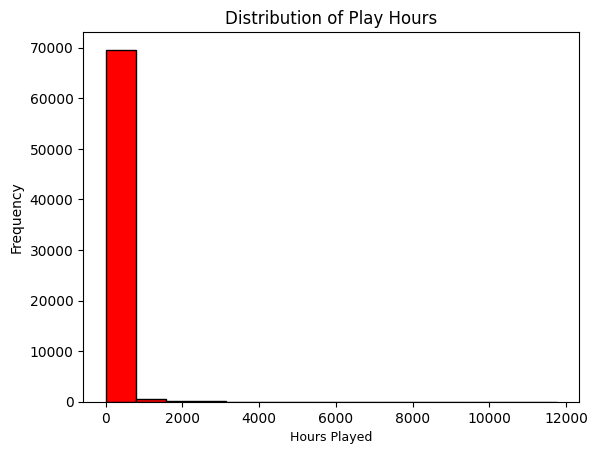

In [0]:
# Histogram of play hours
plt.hist(play_data.toPandas()['Hours_Played'], bins=15, color='red', edgecolor='black')
plt.xlabel('Hours Played', fontsize=9)
plt.ylabel('Frequency')
plt.title('Distribution of Play Hours')
plt.show()

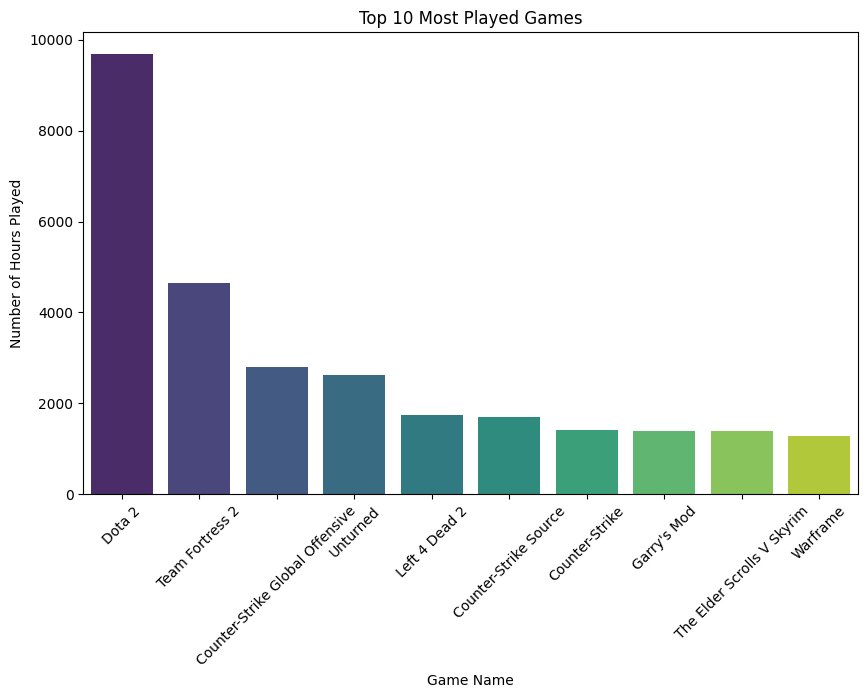

In [0]:
# Top N Games Played
top_n = 10
top_games = steam_df.groupBy('Game_Name').count().orderBy('count', ascending=False).limit(top_n).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='Game_Name', y='count', data=top_games, palette='viridis')
plt.xlabel('Game Name')
plt.ylabel('Number of Hours Played')
plt.title(f'Top {top_n} Most Played Games')
plt.xticks(rotation=45)
plt.show()

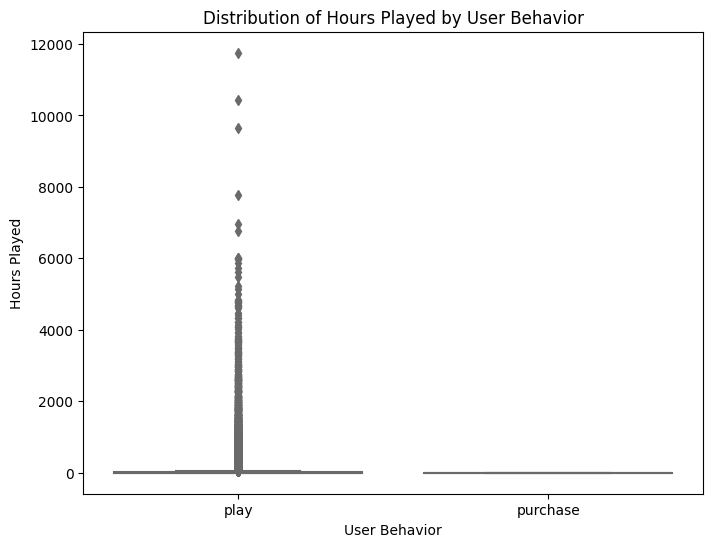

In [0]:
# Boxplot of Hours Played by User Behavior
plt.figure(figsize=(8, 6))
sns.boxplot(x='User_Behavior', y='Hours_Played', data=steam_df.toPandas(), palette='Set3')
plt.xlabel('User Behavior')
plt.ylabel('Hours Played')
plt.title('Distribution of Hours Played by User Behavior')
plt.show()


####  Preprocessing The Data

In [0]:
# Generating unique integer IDs for games based on game names

# Create a window specification
windowSpec = Window.orderBy("game_name")

# Add a row number column
game_id = steam_df.select('game_name').distinct().withColumn("game_id", F.row_number().over(windowSpec))


In [0]:
# Show the DataFrame with added game IDs
game_id.show(5)

+--------------------+-------+
|           game_name|game_id|
+--------------------+-------+
|         007 Legends|      1|
|           0RBITALIS|      2|
|1... 2... 3... KI...|      3|
|     10 Second Ninja|      4|
|          10,000,000|      5|
+--------------------+-------+
only showing top 5 rows



In [0]:
# Join the game IDs with the original DataFrame
steam_df_with_ids = steam_df.join(game_id, on='game_name', how='left')


# Print the schema of the DataFrame with added game IDs
steam_df_with_ids.printSchema()


root
 |-- game_name: string (nullable = true)
 |-- UserID: integer (nullable = true)
 |-- User_Behavior: string (nullable = true)
 |-- Hours_Played: double (nullable = true)
 |-- game_id: integer (nullable = true)



In [0]:
# Handle missing values
training_data = steam_df_with_ids.na.drop(subset=["UserID", "game_id", "Hours_Played"])

In [0]:
# Preprocess data into correct format
preprocess = RFormula(formula="User_Behavior ~ .")
steam_df_with_ids = preprocess.fit(steam_df_with_ids).transform(steam_df_with_ids)
steam_df_with_ids.show(5)

2024/05/01 19:49:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f4ca0d21791d4701a2d6cbf870cd7bda', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


+--------------------+---------+-------------+------------+-------+--------------------+-----+
|           game_name|   UserID|User_Behavior|Hours_Played|game_id|            features|label|
+--------------------+---------+-------------+------------+-------+--------------------+-----+
|The Elder Scrolls...|151603712|         play|       273.0|   4365|(5157,[8,5154,515...|  1.0|
|           Fallout 4|151603712|     purchase|         1.0|   1679|(5157,[100,5154,5...|  0.0|
|           Fallout 4|151603712|         play|        87.0|   1679|(5157,[100,5154,5...|  1.0|
|               Spore|151603712|     purchase|         1.0|   3998|(5157,[332,5154,5...|  0.0|
|               Spore|151603712|         play|        14.9|   3998|(5157,[332,5154,5...|  1.0|
+--------------------+---------+-------------+------------+-------+--------------------+-----+
only showing top 5 rows



In [0]:
# Selecting Game name and ID for recommendation
game_rec =  steam_df_with_ids.select("game_name", "game_id")

In [0]:
# Filter the dataset to include only 'play' behavior
play_data = steam_df_with_ids.filter(steam_df_with_ids['User_Behavior'] == 'play')


In [0]:
# Checking for missing values
steam_df_with_ids.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for c in steam_df.columns]).show()


+------+---------+-------------+------------+
|UserID|game_name|User_Behavior|Hours_Played|
+------+---------+-------------+------------+
|     0|        0|            0|           0|
+------+---------+-------------+------------+



In [0]:
# Arrange in the correct format
play_data_format = play_data.select("UserID", "game_id", "Hours_Played")

In [0]:
# Calculate quartiles
quantiles = play_data_format.approxQuantile('Hours_Played', [0.25, 0.75], 0.05)
 
# Calculate IQR
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1
 
# Define lower and upper bounds for outlier detection
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)
 
# Filter out rows outside the lower and upper bounds
steamplay_df_without_outliers = play_data_format.filter((col('Hours_Played') >= lower_bound) & (col('Hours_Played') <= upper_bound))
 
# Show the cleaned DataFrame
steamplay_df_without_outliers.show()


+---------+-------+------------+
|   UserID|game_id|Hours_Played|
+---------+-------+------------+
|151603712|   3998|        14.9|
|151603712|   1680|        12.1|
|151603712|   2476|         8.9|
|151603712|   2194|         8.5|
|151603712|   3115|         8.1|
|151603712|   3214|         7.5|
|151603712|   2475|         3.3|
|151603712|   4258|         2.8|
|151603712|   4645|         2.5|
|151603712|   4306|         2.0|
|151603712|   1141|         1.4|
|151603712|    523|         1.3|
|151603712|   1360|         1.3|
|151603712|   1675|         0.8|
|151603712|   3629|         0.8|
|151603712|   1977|         0.6|
|151603712|   3451|         0.5|
|151603712|   2657|         0.5|
|151603712|   1473|         0.5|
|151603712|   1337|         0.5|
+---------+-------+------------+
only showing top 20 rows



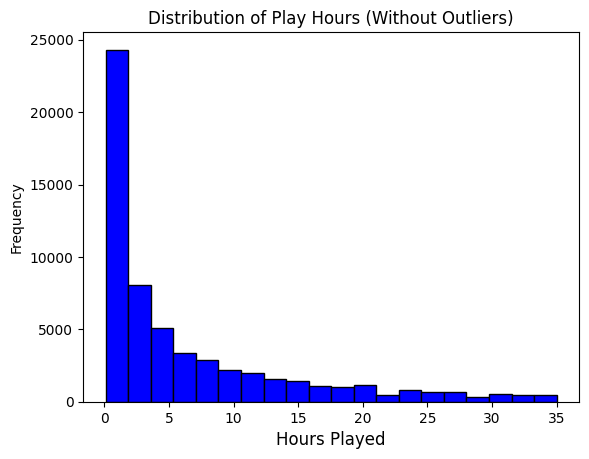

In [0]:
# Plot Histogram to show steamplay_df_without_outliers
plt.hist(steamplay_df_without_outliers.toPandas()['Hours_Played'], bins=20, color='blue', edgecolor='black')
plt.xlabel('Hours Played', fontsize=12)
plt.ylabel('Frequency')
plt.title('Distribution of Play Hours (Without Outliers)')
plt.show()

#### Training the data set

In [0]:
# Split the data into training and testing sets (80% training, 20% test)
(training_data, testing_data) = steamplay_df_without_outliers.randomSplit([0.8, 0.2])

In [0]:
# Initialize the ALS model
als = ALS(maxIter=10, regParam=0.1, userCol="UserID", itemCol="game_id", ratingCol="Hours_Played", seed=100, nonnegative=True)

In [0]:
# Train the model
model = als.fit(training_data)

2024/05/01 19:49:48 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9c4d346d80234dd2bd87b57e909515dc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 19:49:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Valu

In [0]:
# Make predictions on the testing data
predictions = model.transform(testing_data).dropna()

In [0]:
#Display Predictions
predictions.show()

+------+-------+------------+----------+
|UserID|game_id|Hours_Played|prediction|
+------+-------+------------+----------+
|  5250|   1337|         0.2| 0.6859814|
|  5250|   3224|        13.6| 2.3606462|
| 76767|    228|         0.8| 6.5217047|
| 76767|    985|        25.0| 3.8166955|
| 76767|   4493|         1.8| 2.4235954|
| 76767|   4546|         3.4| 7.8114495|
|298950|    258|         7.0|   8.95107|
|298950|    443|         0.6| 11.106953|
|298950|    480|         0.4| 5.1175213|
|298950|    523|        21.0| 7.3012133|
|298950|    619|         8.3| 7.4741015|
|298950|    669|         0.6|  3.849184|
|298950|   1672|         0.3| 2.1783807|
|298950|   1860|         2.7|  6.991619|
|298950|   1944|         1.1| 5.7292275|
|298950|   2346|         0.6| 3.1652093|
|298950|   2376|         5.9|  11.04566|
|298950|   2669|         3.4| 12.641113|
|298950|   2716|         9.8| 12.088427|
|298950|   3075|         0.2|  8.153814|
+------+-------+------------+----------+
only showing top

In [0]:
# Evaluate the model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) = " + str(rmse))

Root Mean Squared Error (RMSE) = 9.336557834147646


In [0]:
# Evaluate the model using Cross-Validation

# Define the ALS model
als = ALS(maxIter=10, regParam=0.1, userCol="UserID", itemCol="game_id", ratingCol="Hours_Played", seed=100, nonnegative=True)

In [0]:
# Define the parameter grid for cross-validation
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20, 30]) \
    .addGrid(als.regParam, [0.05, 0.1, 0.2]) \
    .build()

In [0]:
# Define the evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")

In [0]:
# Create cross-validator
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

In [0]:
# Fit the cross-validator to the training data
cvModel = crossval.fit(training_data)

2024/05/01 19:50:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '035dd0497c6342448fc0f1cf058726bf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:16:15 WARNING mlflow.pyspark.ml: Model CrossValidatorModel_7870931b5210 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


In [0]:
# Make predictions on the testing data
predictions_cv = cvModel.transform(testing_data).dropna()

In [0]:
# Evaluate the model using RMSE
rmse_cv = evaluator.evaluate(predictions_cv)
print("Root Mean Squared Error (RMSE) after cross-validation = " + str(rmse_cv))


Root Mean Squared Error (RMSE) after cross-validation = 10.184608973075635


In [0]:
# Generate top n game recommendations for each user
userRecs = model.recommendForAllUsers(10)
userRecs.show(truncate=False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|UserID  |recommendations                                                                                                                                                                                    |
+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|76767   |[{2941, 60.43472}, {2201, 45.58598}, {3272, 40.22553}, {2630, 38.949577}, {2001, 37.743683}, {2577, 37.657448}, {1067, 37.44007}, {3849, 37.32363}, {1368, 36.99244}, {3796, 36.76098}]            |
|144736  |[{3948, 0.2881585}, {626, 0.28720456}, {3941, 0.28009668}, {1861, 0.26482365}, {365, 0.26388955}, {3552, 0.26295185}, {2941, 0.26232976}, {1694, 0.2507106}, {3919

In [0]:
# Get recommendations for user with user_Id 1
user_id = 151603712
user_recommendations = userRecs.where(userRecs.UserID == user_id) \
                               .select("recommendations") \
                               .withColumn("recommendations", explode("recommendations")) \
                               .select("recommendations.game_id", "recommendations.rating") \
                               .join(game_rec, ["game_id"]) \
                               .show(truncate=False)

+-------+---------+----------------------------+
|game_id|rating   |game_name                   |
+-------+---------+----------------------------+
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |100% Orange Juice           |
|6      |15.70791 |1

In [0]:
# Parameter Tuning
import itertools

param_grid = {'maxIter': [5, 10, 15], 'regParam': [0.001, 0.005, 0.01, 0.05, 0.1]} 
best_rmse = float('inf')
best_params = None

for maxIter, regParam in itertools.product(param_grid['maxIter'], param_grid['regParam']):
    als = ALS(maxIter=maxIter, regParam=regParam, userCol='UserID', itemCol='game_id', ratingCol='Hours_Played', seed=100, nonnegative=True)
    model = als.fit(testing_data)
    predictions = model.transform(testing_data).dropna()
        
    # Evaluate model using RegressionEvaluator
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    print("RMSE for maxIter={}, regParam={}: {}".format(maxIter, regParam, rmse))
        
    # Update best RMSE and parameters if current RMSE is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = (maxIter, regParam)

print("Best RMSE:", best_rmse)
print("Best Parameters:", best_params)


2024/05/01 20:17:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2600343c28d24664a8500e136b092daa', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:17:46 WARNING mlflow.pyspark.ml: Model ALS_721f5b2414e2 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.001: 1.098200582423645


2024/05/01 20:17:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '30a205fdb9184b13846c53f53563889b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:18:08 WARNING mlflow.pyspark.ml: Model ALS_ade0aa6e4b4c will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.005: 1.1043229650940747


2024/05/01 20:18:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c880e71de37c4e06a0cf518f28bd11c7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:18:29 WARNING mlflow.pyspark.ml: Model ALS_daf753d2a5eb will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.01: 1.076505407220855


2024/05/01 20:18:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '31b809396a504099a7b53e5dd73f8a84', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:18:52 WARNING mlflow.pyspark.ml: Model ALS_dadb884804bd will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.05: 1.0889753936535476


2024/05/01 20:18:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2cbcba6a86d948c3b179e82bc10df464', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:19:14 WARNING mlflow.pyspark.ml: Model ALS_af8a0a2624d9 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.1: 1.1525727430764363


2024/05/01 20:19:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'a29a279f4251494b858ad3f31c2dbd85', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:19:49 WARNING mlflow.pyspark.ml: Model ALS_6aadeceed392 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.001: 0.7611121124810402


2024/05/01 20:19:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd3def311475f4b9da4bc74906ddc8f2d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:20:28 WARNING mlflow.pyspark.ml: Model ALS_e437d059a9fb will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.005: 0.7522453813330854


2024/05/01 20:20:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '99af638ec271440eb4ceba35a3899600', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:21:06 WARNING mlflow.pyspark.ml: Model ALS_7f845cddcad5 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.01: 0.734165158565465


2024/05/01 20:21:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c6689babd7924d22864302d41af121c5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:21:44 WARNING mlflow.pyspark.ml: Model ALS_2883bf9bd0af will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.05: 0.7529530849685248


2024/05/01 20:21:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9ca40e710cae478494c45550a5064476', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:22:22 WARNING mlflow.pyspark.ml: Model ALS_92584be8de7c will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.1: 0.8545760681368558


2024/05/01 20:22:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c56c346814bf48c781f7b181195f31a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:23:27 WARNING mlflow.pyspark.ml: Model ALS_e10e07c328cb will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.001: 0.563467076677702


2024/05/01 20:23:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd4ec1ed8a41d4d61abaaad8130850b70', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:24:34 WARNING mlflow.pyspark.ml: Model ALS_7df98b887fd1 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.005: 0.6110075080078502


2024/05/01 20:24:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ece83a5c91b34a40886adebc2d4c6e44', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:25:40 WARNING mlflow.pyspark.ml: Model ALS_8916bed86d04 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.01: 0.5633585157714922


2024/05/01 20:25:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd65e46fa06944fb7ba3f9572e3ea377a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:26:49 WARNING mlflow.pyspark.ml: Model ALS_23114c2dcaec will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.05: 0.6244966643064842


2024/05/01 20:27:02 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ab1a262869f54a3bbc35dd1385c3c08b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:27:57 WARNING mlflow.pyspark.ml: Model ALS_7162b88f1805 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.1: 0.708982762983896
Best RMSE: 0.5633585157714922
Best Parameters: (15, 0.01)


2024/05/01 20:28:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5e85150cb807418da18a4f07b1352192', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:28:25 WARNING mlflow.pyspark.ml: Model ALS_b214b334faf9 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.001: 1.098200582423645


2024/05/01 20:28:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '356eaec607a84b729ff1cd8b22df9a6e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:28:46 WARNING mlflow.pyspark.ml: Model ALS_707fef915624 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.005: 1.1043229650940747


2024/05/01 20:28:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'af82f50b54e643b893eecd9c6fa20089', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:29:07 WARNING mlflow.pyspark.ml: Model ALS_f5d4ed6d4ce5 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.01: 1.076505407220855


2024/05/01 20:29:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '18849bc9c18a4398a926c0991ed19a22', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:29:29 WARNING mlflow.pyspark.ml: Model ALS_d99c4b39eb16 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.05: 1.0889753936535476


2024/05/01 20:29:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0289ef7753c84f34a9643bee905e6274', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:29:52 WARNING mlflow.pyspark.ml: Model ALS_cb53a317c5ed will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=5, regParam=0.1: 1.1525727430764363


2024/05/01 20:29:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3b3a06d53d0f4f1297e4670b1afc8131', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:30:28 WARNING mlflow.pyspark.ml: Model ALS_c0a878b73d7d will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.001: 0.7611121124810402


2024/05/01 20:30:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '605c7c53248642cc8d83c452a1552c44', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:31:05 WARNING mlflow.pyspark.ml: Model ALS_7c2ba7dcee65 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.005: 0.7522453813330854


2024/05/01 20:31:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4b158ca5a2024c53be52c7805c578a31', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:31:43 WARNING mlflow.pyspark.ml: Model ALS_c8cc23e327d5 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.01: 0.734165158565465


2024/05/01 20:31:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '83d05ce81cb84ad9a6156c5da3d4cf85', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:32:21 WARNING mlflow.pyspark.ml: Model ALS_226494385f1c will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.05: 0.7529530849685248


2024/05/01 20:32:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '131ede96663f400c9c4e6e07150aa8e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:32:59 WARNING mlflow.pyspark.ml: Model ALS_92b7f8cc6ea0 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=10, regParam=0.1: 0.8545760681368558


2024/05/01 20:33:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '760d66ba73a54478811adf5478ee63ee', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:34:02 WARNING mlflow.pyspark.ml: Model ALS_b2dfbdd804d4 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.001: 0.563467076677702


2024/05/01 20:34:15 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6edb8dcc7bdc4f728b680292eaa59e18', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:35:08 WARNING mlflow.pyspark.ml: Model ALS_e53ffeab3675 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.005: 0.6110075080078502


2024/05/01 20:35:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2feb8a1ff4ea44d6b218ff12f3b1e88e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:36:16 WARNING mlflow.pyspark.ml: Model ALS_1220e1eb5de8 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.01: 0.5633585157714922


2024/05/01 20:36:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f8fdc100e7754522b370cb671ac26ec4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:37:24 WARNING mlflow.pyspark.ml: Model ALS_9414e659e515 will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.05: 0.6244966643064842


2024/05/01 20:37:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ad621fe4a3a847b7a1420b89d2e8a26b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/05/01 20:38:28 WARNING mlflow.pyspark.ml: Model ALS_d2fa6aa7c4eb will not be autologged because it is not allowlisted or or because one or more of its nested models are not allowlisted. Call mlflow.spark.log_model() to explicitly log the model, or specify a custom allowlist via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile Spark conf (see mlflow.pyspark.ml.autolog docs for more info).


RMSE for maxIter=15, regParam=0.1: 0.708982762983896


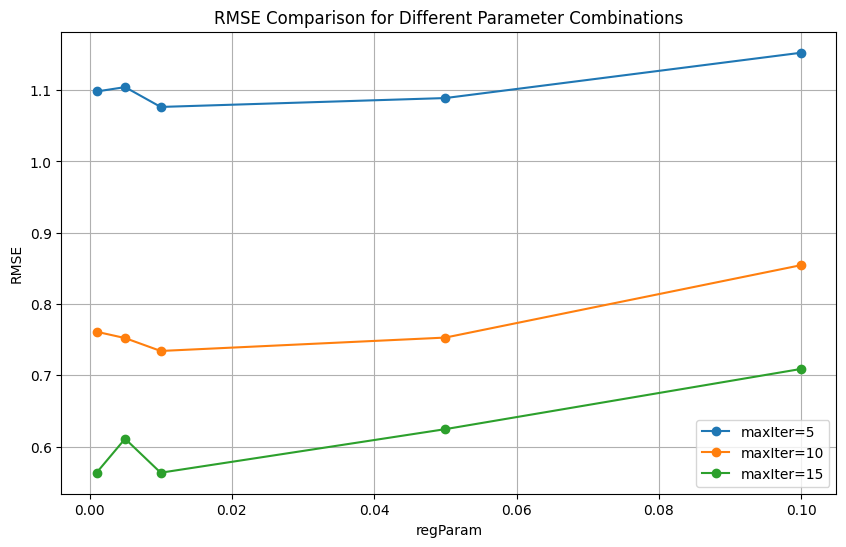

In [0]:
# Parameter Tuning With plotting
param_grid = {'maxIter': [5, 10, 15], 'regParam': [0.001, 0.005, 0.01, 0.05, 0.1]} 
rmse_values = []

for maxIter in param_grid['maxIter']:
    for regParam in param_grid['regParam']:
        als = ALS(maxIter=maxIter, regParam=regParam, userCol='UserID', itemCol='game_id', ratingCol='Hours_Played', seed=100, nonnegative=True)
        model = als.fit(testing_data)
        predictions = model.transform(testing_data).dropna()
        
        # Evaluate model using RegressionEvaluator
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="Hours_Played", predictionCol="prediction")
        rmse = evaluator.evaluate(predictions)
        print("RMSE for maxIter={}, regParam={}: {}".format(maxIter, regParam, rmse))
        
        # Append RMSE value to the list
        rmse_values.append((maxIter, regParam, rmse))

# Convert list of tuples to a DataFrame
rmse_df = pd.DataFrame(rmse_values, columns=['maxIter', 'regParam', 'RMSE'])

# Plot RMSE comparison
plt.figure(figsize=(10, 6))
for maxIter in param_grid['maxIter']:
    subset = rmse_df[rmse_df['maxIter'] == maxIter]
    plt.plot(subset['regParam'], subset['RMSE'], marker='o', label=f'maxIter={maxIter}')

plt.title('RMSE Comparison for Different Parameter Combinations')
plt.xlabel('regParam')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()
